In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Dot, Embedding, Flatten, Activation
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../artifacts/raw/animelist.csv', low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [3]:
data.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [4]:
n_rating = data['user_id'].value_counts()
n_rating

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [5]:
len(data)

5000000

In [6]:
rating_df = data[data['user_id'].isin(n_rating[n_rating >400].index)].copy()

In [7]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [8]:
len(rating_df)

3242641

In [9]:
min_rating = min(rating_df['rating'])
min_rating

0

In [10]:
max_rating = max(rating_df['rating'])
max_rating

10

In [11]:
avg_rating = rating_df['rating'].mean()
avg_rating

np.float64(4.122023992171813)

In [12]:
rating_df['rating'] = rating_df['rating'].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [13]:
rating_df

,user_id,anime_id,rating
213,2,24833,0.0
214,2,235,1.0
215,2,36721,0.0
216,2,40956,0.0
217,2,31933,0.0
...,...,...,...
4999916,16507,8985,0.0
4999917,16507,5454,0.0
4999918,16507,15911,0.0
4999919,16507,878,0.0


In [14]:
min(rating_df['rating']), max(rating_df['rating'])


(0.0, 1.0)

In [16]:
np.mean(rating_df['rating'])

np.float64(0.41220239921718105)

In [17]:
rating_df.duplicated().sum()

np.int64(0)

In [18]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [22]:
user_ids = rating_df['user_id'].unique().tolist()
len(user_ids)   

4193

In [25]:
user2user_encoder = {x : i for i , x in enumerate(user_ids)}
user2user_decoder = {i : x for i, x in enumerate(user_ids)}

In [26]:
user2user_encoder

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [27]:
user2user_decoder

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [28]:
rating_df['user'] = rating_df['user_id'].map(user2user_encoder)

In [30]:
anime_ids = rating_df['anime_id'].unique().tolist()
len(anime_ids)  

17149

In [31]:
anime2anime_encoder = {x : i for i , x in enumerate(anime_ids)}

anime2anime_decoder = {i : x for i, x in enumerate(anime_ids)}

In [32]:
anime2anime_encoder

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [33]:
anime2anime_decoder

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 

In [34]:
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoder)

In [35]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [42]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [58]:
X = rating_df[['user', 'anime']].values
X

array([[ 991, 3527],
       [ 587, 1027],
       [ 585, 1259],
       ...,
       [2878,  127],
       [3562, 1214],
       [2867, 3413]])

In [59]:
y = rating_df['rating']
y.head()

0    1.0
1    0.4
2    0.0
3    0.9
4    0.0
Name: rating, dtype: float64

In [60]:
test_size = 1000
train_size = len(X) - test_size

In [61]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [62]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3241641, 1000, 3241641, 1000)

In [63]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [64]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

In [65]:
X_train_array

[array([ 991,  587,  585, ...,  560, 3811, 2120]),
 array([3527, 1027, 1259, ..., 1461, 1138, 1205])]

In [79]:
def RecommnederNet():
    embedding_size = 128
    user = Input(name = "user", shape=[1])
    
    user_embedding = Embedding(name = "user_embedding", input_dim=len(user_ids), output_dim=embedding_size)(user)
    
    anime = Input(name = "anime", shape=[1])
    
    anime_embedding = Embedding(name = "anime_embedding", input_dim=len(anime_ids), output_dim=embedding_size)(anime)
    
    x = Dot(name = "dot_product", axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['mae', 'mse'])
    return model
    

In [80]:
model = RecommnederNet()

In [81]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,782 (10.42 MB)

 Trainable params: 2,731,780 (10.42 MB)

 Non-trainable params: 2 (8.00 B)

In [86]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        lr = (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr

In [87]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode = 'min', save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)


In [88]:
my_callbacks = [lr_callback, model_checkpoint, early_stopping]

In [89]:

history = model.fit(x=X_train_array,
          y=y_train, 
          batch_size=batch_size, 
          epochs=20, 
          validation_data=(X_test_array,y_test), 
          callbacks=my_callbacks,
          verbose=1)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 0.7285 - mae: 0.3683 - mse: 0.1716 - val_loss: 0.7300 - val_mae: 0.3654 - val_mse: 0.1707 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.7273 - mae: 0.3678 - mse: 0.1709 - val_loss: 0.7290 - val_mae: 0.3652 - val_mse: 0.1702 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.7245 - mae: 0.3669 - mse: 0.1697 - val_loss: 0.7270 - val_mae: 0.3649 - val_mse: 0.1693 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - loss: 0.7210 - mae: 0.3659 - mse: 0.1682 - val_loss: 0.7247 - val_mae: 0.3645 - val_mse: 0.1683 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.7163 - mae: 0.3642 - mse: 0.1660 - val_loss: 0.7220 - val_mae: 0.3640 - val_mse: 0.1671 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.7100 - mae: 0.3619 - mse: 0.1632 - v

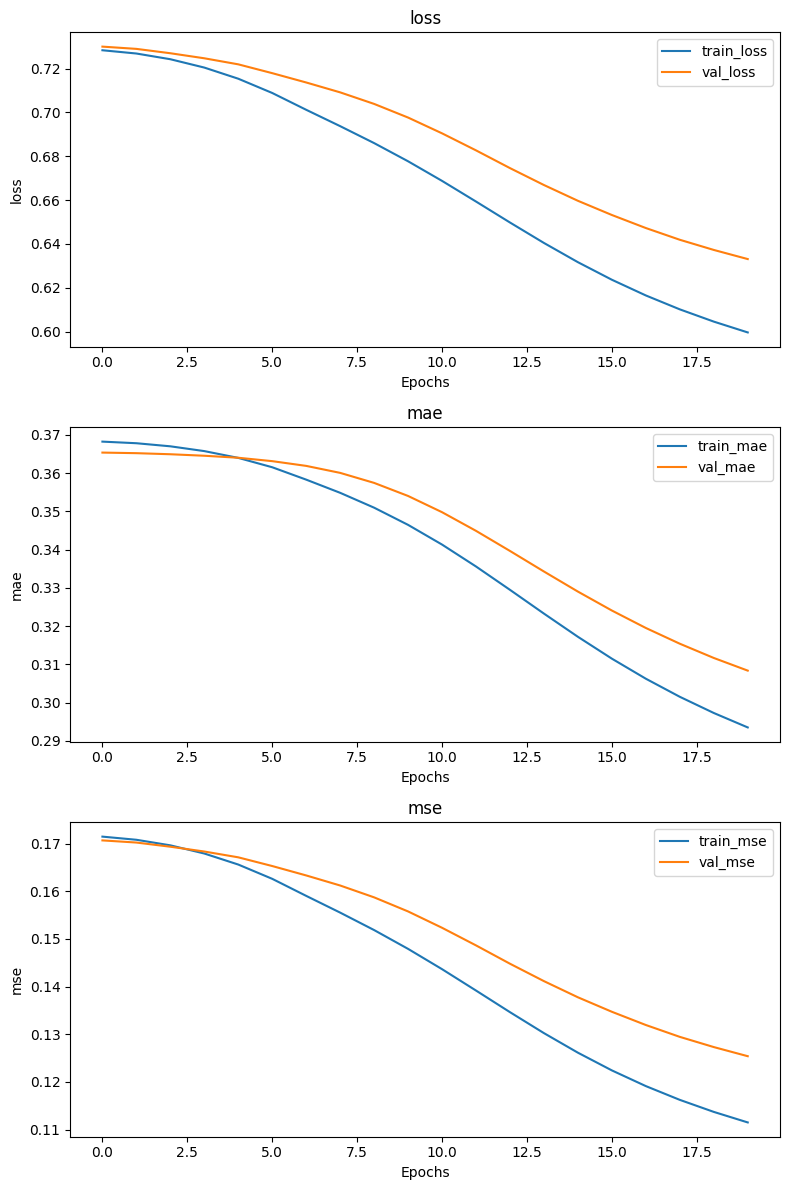

In [90]:
metrics = ['loss', 'mae', 'mse']

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    axes[i].plot(history.history[metric], label='train_' + metric)
    axes[i].plot(history.history['val_' + metric], label='val_' + metric)
    axes[i].set_title(metric)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    
plt.tight_layout()
plt.show()

In [93]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [94]:
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [95]:
anime_weights

array([[-0.02461537,  0.07117705,  0.08940719, ...,  0.2015232 ,
         0.10789045,  0.05651018],
       [-0.03241795,  0.00050938,  0.06947339, ...,  0.14355703,
        -0.02846243, -0.00339379],
       [ 0.11589135, -0.07435174, -0.05402281, ..., -0.01092334,
        -0.07813884,  0.12656842],
       ...,
       [-0.06558507, -0.01732142,  0.13504447, ..., -0.00960109,
         0.11654244,  0.13125813],
       [ 0.02390764,  0.03086767, -0.09628702, ...,  0.07267936,
        -0.06602207, -0.02492594],
       [ 0.06507973, -0.09834906, -0.02873857, ..., -0.07360998,
        -0.03385247,  0.00800184]], dtype=float32)